## Introduction

### Problem statement

Analyzing sentiment in social media, particularly Twitter, presents a complex challenge due to the diverse nature of user-generated content and the nuances of language. Traditional methods often struggle with the variability and noise inherent in Twitter data, which includes slang, sarcasm, and varying sentence structures. These factors can complicate sentiment classification, affecting the accuracy of predictive models.

This project aims to develop an advanced sentiment analysis model using Twitter data, focusing on classifying tweets as positive or negative based on their content. We aim to employ Natural Language Processing (NLP) techniques for robust text preprocessing, including tokenization, stopwords removal, and lemmatization.
The model will utilize Logistic Regression, a well-established classification algorithm, to accurately predict sentiment labels. The insights gained from this analysis will provide a valuable understanding of public sentiment trends on Twitter, facilitating applications in market research, brand management, and social listening.


## Prepare Data

### Dataset description
The dataset we are using for this project is Kaggle's [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140), which can be downloaded from the provided link.The sentiment140 dataset contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (`0 = negative, 4 = positive`) and they can be used to detect sentiment .
It contains the following 6 fields:

1.`target`: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

2.`ids`: The id of the tweet ( 2087)

3.`date`: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

4.`flag`: The query (lyx). If there is no query, then this value is NO_QUERY.

5.`user`: the user that tweeted (robotickilldozr)

6.`text`: the text of the tweet (Lyx is cool)


### Data Collection

Given the size of our dataset, we utilize the Kaggle API to seamlessly transfer data from Kaggle's environment to Google Colab. Begin by generating a new API token in your Kaggle account, which will download a kaggle.json file. Upload this file to your Colab environment:

Upload the kaggle.json file

In [4]:
# configure the path to your json file

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json


Import the Twitter Sentiment140 dataset

In [5]:
# Fetch the dataset from Kaggle
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 87% 70.0M/80.9M [00:00<00:00, 190MB/s]
100% 80.9M/80.9M [00:00<00:00, 164MB/s]


The data has been downloaded as a `zip` file but we need to extract the `csv` file that we can use in our project.

In [6]:
#use the Zipfile module to extract from zipfile

from zipfile import ZipFile
filepath = '/content/sentiment140.zip'

#Extract the data from the zipfile
with ZipFile(filepath, 'r') as data:
  data.extractall()
  print("Done extracting the data!")

Done extracting the data!


Import the necessary libraries required for the analysis


In [58]:
import numpy as np #for numeric operations
import pandas as pd # for dataframes
import re # for pattern matching
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Data Preprocesssing

In [9]:
# Load dataset
column_names = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", names=column_names, encoding='ISO-8859-1')
df.shape

(1600000, 6)

Our dataset contains 1.6: million rows (`tweets`) and 6 columns.

In [10]:
# Display the first 5 tweets
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [11]:
#check for any missing values in each of the columns
df.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

The dataframe does not contain any missing values!

For this project we will focus on two columns, the `target` and the `text` column. The target column specifies the label of our tweet, whether it is positive or negative, and the text column has the content of the tweet.

Let's check for the distribution of the target column values.

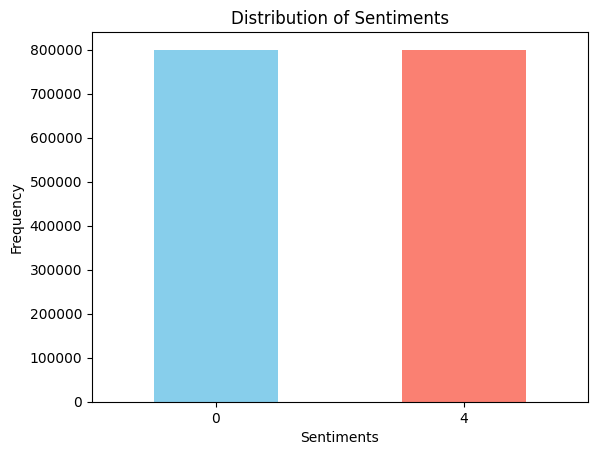

In [12]:
# Plot the distribution as a bar chart
df['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiments')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

The dataset has an equal distribution of positive and negative sentiments, ensuring a balanced class representation. As a result, we do not need to address issues of class imbalance before performing binary classification.

For a more intuitive binary classification, it is beneficial to have class labels where 0 represents negative sentiments and 1 represents positive sentiments. Therefore, we will change the class label from 4 to 1 to achieve this format.

In [13]:
# change 4 to 1
df['target'].replace({4: 1}, inplace=True)
df['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

 <b>Stop Words</b>

 `Stopwords` are frequently used words that carry little meaning on their own.
 Examples: `"the", "a", "an", "is", "are", "in", "on"`.

 We remove stop words to allow the model to focus on the important words that convey the message.

In [ ]:
#Print the stopwords in English
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

<b> Stemming</b>

Stemming is used in NLP to reduce words to their root form. This ensures that words with the same root or stem are treated as the same word, even if they appear in different forms. For example, the words "running", "runner", and "ran" can all be reduced to the stem "run". It helps reduce dimentionality.

In [14]:
#Instantiate the stemming module
stemmer = PorterStemmer()

To enhance our text data, we need to stem words to their root forms. However, the `text` column requires several cleaning steps before stemming can be effectively applied:

* Eliminate any characters that are not part of the alphabet because we do not need them.
* Standardize all text to lowercase
* Split text into individual words
* Remove common stop words that do not contribute meaningful information.
* Stem the words

To streamline these tasks, we will create a custom function called `stemming_func` that performs all these preprocessing steps in one go.

In [15]:
# the stemming function
def stemming_func(text):
    # Define stop words
    stop_words = set(stopwords.words('english'))

    # Remove non-alphabet characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Split text into individual words
    words = text.split()
    # Exclude stop words and stem the remaining words
    stemmed_words = [stemmer.stem(word) for word in words if word not in stop_words]


    return ' '.join(stemmed_words)

Create a new column that contains the stemmed words

In [16]:
df['stemmed_text'] = df['text'].apply(stemming_func) # Took 10 minutes to run

In [17]:
# Display the df
df.head()

,target,ids,date,flag,user,text,stemmed_text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot httptwitpiccomyzl awww that bummer ...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset cant updat facebook text might cri resul...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav im mad cant see


The `stemmed_text` column has been created and has been cleaned as per the function.

Now that we have preprocessed the necessary columns with the required data for the model, let's define our feature and target variables. We aim to use the text from a tweet to determine whether the sentiment is positive or negative. Thus, our feature variable will be `stemmed_text`, and the target variable will be the `target` column.

In [18]:
#Define feature and target
X = df['stemmed_text']
y = df['target']

<b> Split data to training and testing sets

In [19]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((1280000,), (320000,))

The data is split by 80-20 ratio where 80% of the data (80% of 1.6million)  is used for training and 20% for testing.

<b>Feature Extraction</b>

To train our model, we need to convert the text in our feature variable into numerical values, as the model cannot directly process textual data. For this purpose, we will use the `TF-IDF` (Term Frequency-Inverse Document Frequency) vectorizer. The TF-IDF vectorizer transforms the text data into numerical representations by considering both the frequency of terms in each document and the inverse frequency of the terms across all documents. This method helps to highlight the important words while reducing the weight of common, less informative words, thus improving the effectiveness of our model.



In [20]:
#convert textual data to numerical format
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

## Model Building

<b>Training the Logistic Regression Model

In [21]:
import time
# instantiate the model
model = LogisticRegression(max_iter=1000)
start_time = time.time()
# fit on the training data
model.fit(X_train, y_train)
end_time = time.time()

single_fit_time = end_time - start_time
print(f"Time taken for a single fit: {single_fit_time:.2f} seconds")

Time taken for a single fit: 138.72 seconds


## Evaluate Performance

We use the `accuracy_score` to assess the performance of our model

In [22]:
#Generate predictions using the trained model and assess performance

training_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, model.predict(X_test))

#Display the accuracy score
print(f"The accuracy score on the training data: {round(training_accuracy, 4) * 100}%")
print(f"The accuracy score on the test data: {round(test_accuracy, 4) * 100}%")

The accuracy score on the training data: 81.73%
The accuracy score on the test data: 78.28%


The accuracy score indicates that the model correctly predicts the sentiment of approximately 78.28% of the tweets in the test dataset. This performance suggests that the logistic regression model is reasonably effective in distinguishing between positive and negative sentiments based on tweet text.

While this accuracy is a strong starting point, it is crucial to examine other metrics to comprehensively evaluate the model's performance. We will utilize confusion matrix metrics to gain deeper insights into the model's effectiveness and identify areas for improvement.

In [60]:
# Predict the test set results
y_pred = model.predict(X_test)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.77      0.78    159494
    Positive       0.78      0.80      0.79    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



The logistic regression model shows strong and balanced performance across both positive and negative classes with precision, recall, and F1-scores all around 0.78-0.79.

The balanced support for both classes and similar performance metrics suggest that the model is reliable and does not favor one class over the other.

Overall accuracy is high, indicating that the model is effective for sentiment analysis in this context.
There is still a small margin for improvement, especially in optimizing recall for the negative class to match the positive class performance.

## Results

In this project, we developed a logistic regression model to classify tweets as either positive or negative. After thorough data preprocessing and model tuning, we achieved the following results:

The accuracy score on the training data: 81.73%
The accuracy score on the test data: 78.28%
These results indicate that our logistic regression model performs well in classifying the sentiment of tweets, achieving a high level of accuracy. The slight drop in accuracy from the training data to the test data suggests a good generalization capability of the model, although there might still be room for improvement.

Overall, logistic regression has proven to be an effective method for this binary classification task, providing a solid foundation for further enhancements or integration into larger systems for sentiment analysis.

### Implications for Stakeholders
The logistic regression model provides a reliable method for sentiment analysis, offering valuable insights into public opinion as expressed on Twitter. This can be particularly useful for monitoring brand sentiment, customer feedback, and market trends. While the current model performs well, ongoing refinements and the integration of additional data sources could further enhance its accuracy and reliability.

By leveraging this model, stakeholders can make more informed decisions based on real-time sentiment analysis, ultimately driving better strategies and outcomes.



<b>Challanges and solution</b>

* When initially importing data from Kaggle, the column headers did not import correctly. To resolve this issue, I referenced the dataset description where all the column names were specified. I created a variable named column_names and set the dataframe's column parameter to this variable, ensuring accurate data import.

* The stemming function stemming_func requires significant processing time due to the dataset's large size. In my case, it took up to 10 minutes to complete.
* Due to the dataset's size, hyperparameter tuning is computationally intensive. To mitigate this, I created a subset of the dataset for tuning. Surprisingly, the best parameters identified on this subset closely resembled the default parameters of the logistic regression model.